In [168]:
#Libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [169]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


In [170]:
#Grabbing Datasets
hd_train = pd.read_csv('./datasets/house-train.csv')

#Grab Feature Columns
feature_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
            'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
            'LotFrontage','WoodDeckSF','OpenPorchSF',
            'ExterQual','Neighborhood','MSZoning',
            'Alley','LotShape','LandContour','Condition1','HouseStyle',
            'MasVnrType','SaleCondition',]

features = hd_train[feature_cols].copy()
target = hd_train['SalePrice'].values.reshape(-1,1)

#Convert to floats and handle NaN values + scaling
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)

In [171]:
#Train-Test Split
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size= 0.2, random_state= 0)

#training tensors
x_trainT = torch.tensor(x_train, dtype=torch.float32)
y_trainT = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

#Validation Tensors
x_valT = torch.tensor(x_val, dtype=torch.float32)
y_valT = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [172]:
#Data Loaders
train_dataset = TensorDataset(x_trainT, y_trainT)
valid_dataset = TensorDataset(x_valT, y_valT)

training_loader = DataLoader(dataset= train_dataset, batch_size= 16, shuffle= True)
valid_loader = DataLoader(dataset= valid_dataset, batch_size= 16, shuffle= False)


In [173]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []
rmse = 0


#Regression TL
def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for inputs, targets in training_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      loss_train += loss.item() * inputs.size(0)

    loss_train /= len(training_loader.dataset)
    train_loss_list.append(loss_train) 

    
    #Validation Loop
    model.eval()
    total = 0.0
    valid_loss = 0.0
    
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item() * inputs.size(0)
          total += ((outputs - labels) ** 2).sum().item()
              
    valid_loss /= len(valid_loader.dataset)
    val_loss_list.append(valid_loss)
    rmse = np.sqrt(total / len(valid_loader.dataset))

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}, RMSE: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader), rmse))
  

Problem 2A - No One-Hot encoding

In [174]:
#Model
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(21, 256)  # 6 input features
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [175]:
#Training
model = RegressionNet().to(device)
a = 0.001
epochs = 100
lossFN = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= a)

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader,
)

Epoch: 1, Training Loss: 532153465.25051606, Validation Loss: 2094457210.001442, RMSE: 199486.05713188928
Epoch: 5, Training Loss: 496589464.47588664, Validation Loss: 1878985473.291997, RMSE: 188946.35215464717
Epoch: 10, Training Loss: 136954139.43028712, Validation Loss: 514352757.7563086, RMSE: 98856.97950761931
Epoch: 15, Training Loss: 65471235.41077125, Validation Loss: 406074056.44412404, RMSE: 87837.38994550303
Epoch: 20, Training Loss: 54989292.06380184, Validation Loss: 349834818.07642394, RMSE: 81528.28676877772
Epoch: 25, Training Loss: 46336103.115781575, Validation Loss: 304525102.32732517, RMSE: 76065.609471161
Epoch: 30, Training Loss: 38971928.211671986, Validation Loss: 268046116.7296323, RMSE: 71364.39040490022
Epoch: 35, Training Loss: 32780648.160630513, Validation Loss: 234803817.02090845, RMSE: 66792.75801609977
Epoch: 40, Training Loss: 27601867.66147495, Validation Loss: 208838438.57534245, RMSE: 62991.51000675811
Epoch: 45, Training Loss: 23627128.914242823, 

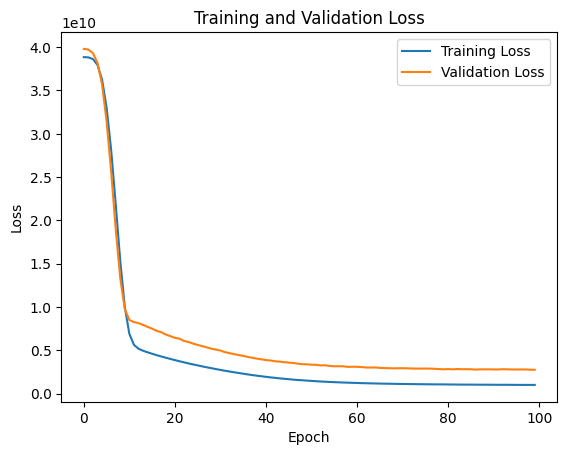

In [176]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()